# Case de entrada para iFood

Candidato: Guilherme Zuccolotto Soriano

## Import de pacotes a serem utilizados

#### Pacotes para manipulação de dados

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt

#### Pacotes para modelagem (clusterização e predição)

In [4]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Import de Base e Análise exploratória

In [5]:
df = pd.read_csv("ml_project1_data.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [7]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


Vamos verificar as variáveis de resposta da campanha, e verificar os clientes que tiveram positivo para a campanha.

Vamos criar uma variável Target, que resume todas as tentativas de contato, para verificar quem foi o cliente que aceitou. E vamos construir uma variável Attempts, que vai me mostrar em qual tentativa de contato o cliente aceitou, em uma coluna.

In [8]:
df['Target'] =\
            np.where(((df['AcceptedCmp1'] == 1) | (df['AcceptedCmp2'] == 1) |(df['AcceptedCmp3'] == 1)|(df['AcceptedCmp4'] == 1)|(df['AcceptedCmp5'] == 1)|(df['Response'] == 1)), 1, 0)

In [9]:
df['Attempts'] =\
            np.where((df['AcceptedCmp1'] == 1), 1,
            np.where((df['AcceptedCmp2'] == 1), 2,
            np.where((df['AcceptedCmp3'] == 1), 3,
            np.where((df['AcceptedCmp4'] == 1), 4,
            np.where((df['AcceptedCmp5'] == 1), 5,
            np.where((df['Response'] == 1), 6, 0))))))

In [10]:
df['Target'].unique()

array([1, 0])

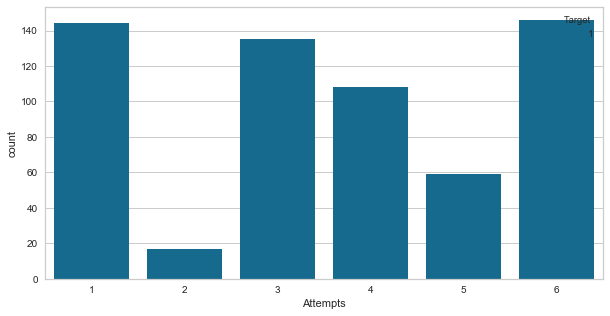

In [11]:
plt.figure(figsize=(10,5))
sns.countplot(x='Attempts',hue='Target',data=df[df['Target']==1])

In [12]:
df.drop(columns=(['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response']), inplace=True)

In [13]:
print(f'Tivermos {df.Target.value_counts()[1]} clientes que aceitaram a oferta em alguma das campanhas, correspondendo a {(((df.Target.value_counts()[1])/df.shape[0])*100):.2f}% de todos os clientes impactados')

Tivermos 609 clientes que aceitaram a oferta em alguma das campanhas, correspondendo a 27.19% de todos os clientes impactados


# Analisando as variáveis categóricas

Aqui vamos olhar a relação da variável resposta criada, para verificar qual a realação das variáveis categóricas com ela, tentando encontrar boas variáveis para a segmentação futura

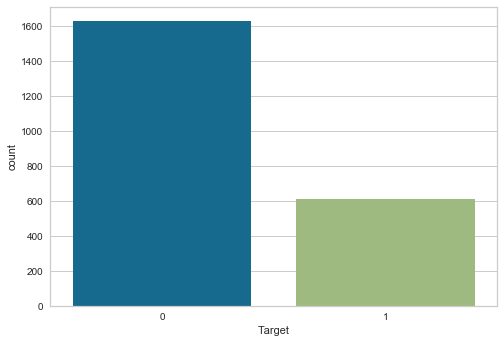

In [14]:
sns.countplot(df.Target)

In [15]:
def analise_categoricas(base,variavel):
    plt.figure(figsize=(20,6))
    f, axes = plt.subplots(1, 2, figsize=(20,6), sharex=True)
    sns.countplot(x=variavel,hue='Target',data=base,palette="rocket" ,ax=axes[0])
    
    sns.barplot(x=variavel, y='Target', data=base, palette="rocket",ax=axes[1])


<Figure size 1440x432 with 0 Axes>

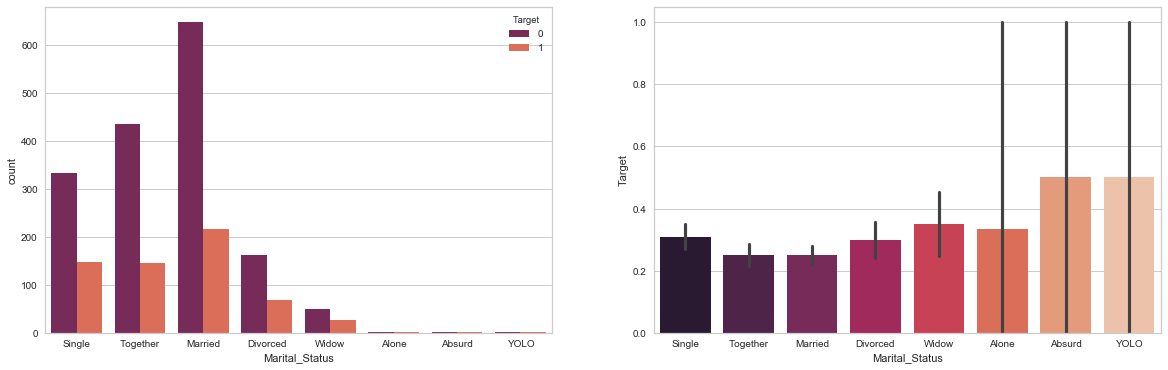

In [16]:
analise_categoricas(df,'Marital_Status')

Notamos que pessoas que estão casadas ou juntas tem uma probabilidade um pouco menor de aceitar a oferta, vamos usar essa informação para criar uma variável agregada "Married", onde nós agrupamos quem está Solteiro, Junto ou sem informação.

In [17]:
df['Married'] =\
            np.where(((df['Marital_Status'] == 'Married') | (df['Marital_Status'] == 'Together')),2,
            np.where(((df['Marital_Status'] == 'Single') | (df['Marital_Status'] == 'Divorced')| (df['Marital_Status'] == 'Alone')),1,0))

<Figure size 1440x432 with 0 Axes>

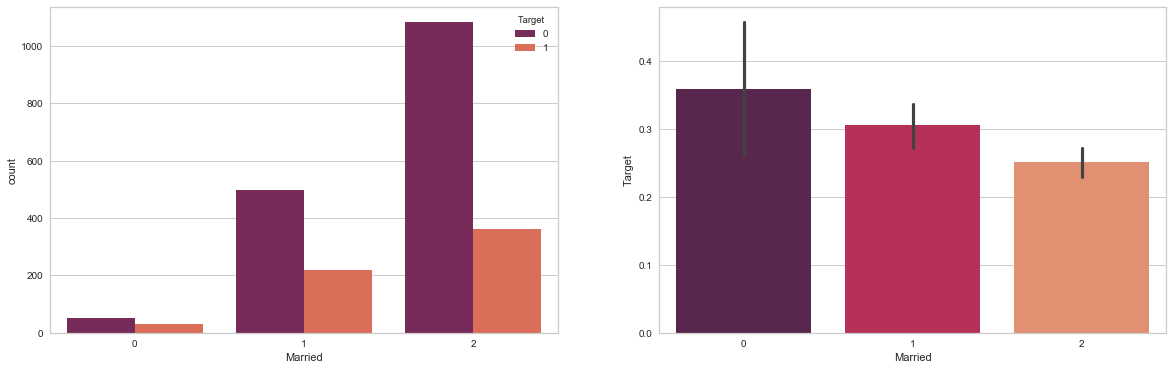

In [18]:
analise_categoricas(df,'Married')

<Figure size 1440x432 with 0 Axes>

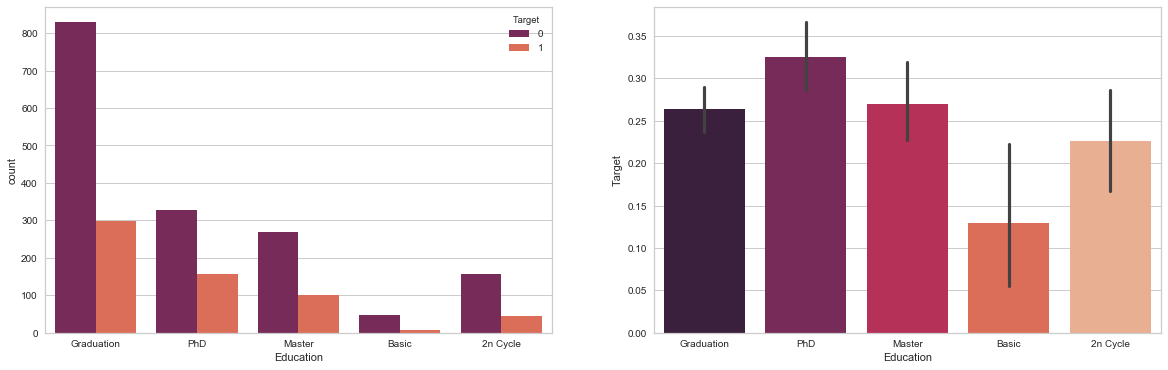

In [19]:
analise_categoricas(df,'Education')

<Figure size 1440x432 with 0 Axes>

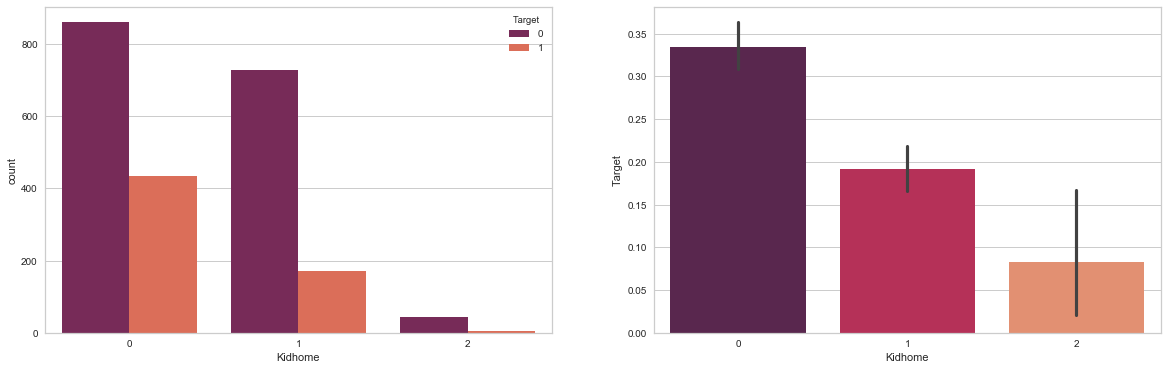

In [20]:
analise_categoricas(df,'Kidhome')

<Figure size 1440x432 with 0 Axes>

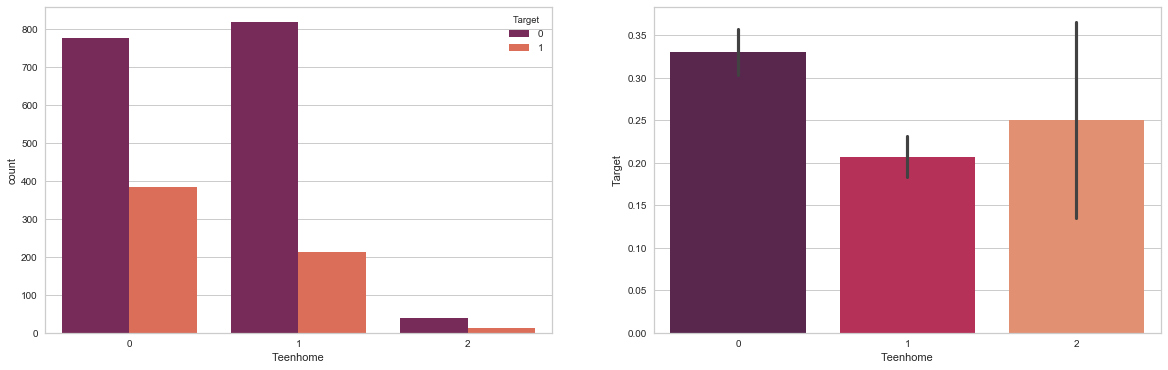

In [21]:
analise_categoricas(df,'Teenhome')

<Figure size 1440x432 with 0 Axes>

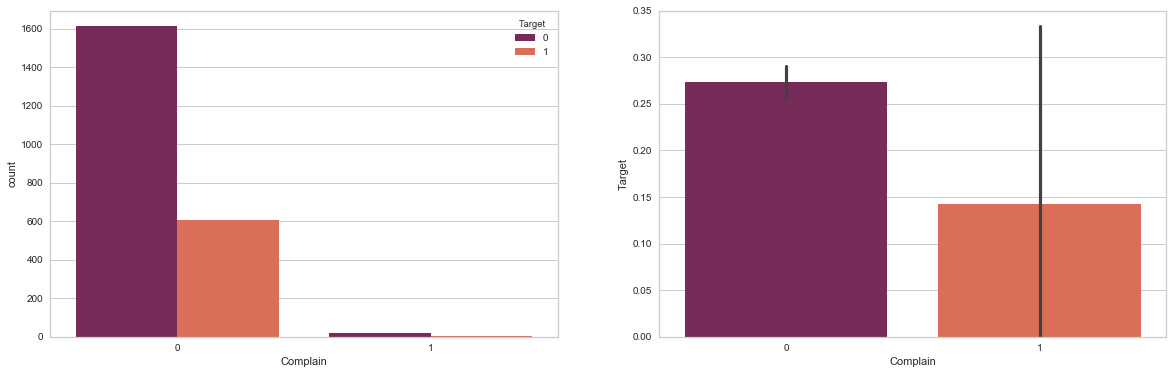

In [22]:
analise_categoricas(df,'Complain')

Olhando para Kidhome e Teenhome, podemos notar que quem não tem filhos parece ter uma probabilidade maior de aceitar a oferta, vamos fazer uma coluna summarizada com os filhos

In [23]:
df['Children'] =\
            np.where(((df['Teenhome'] > 0) | (df['Kidhome'] > 0)), 1, 0)

In [24]:
df['AmtKids'] = df['Teenhome'] + df['Kidhome'] 

<Figure size 1440x432 with 0 Axes>

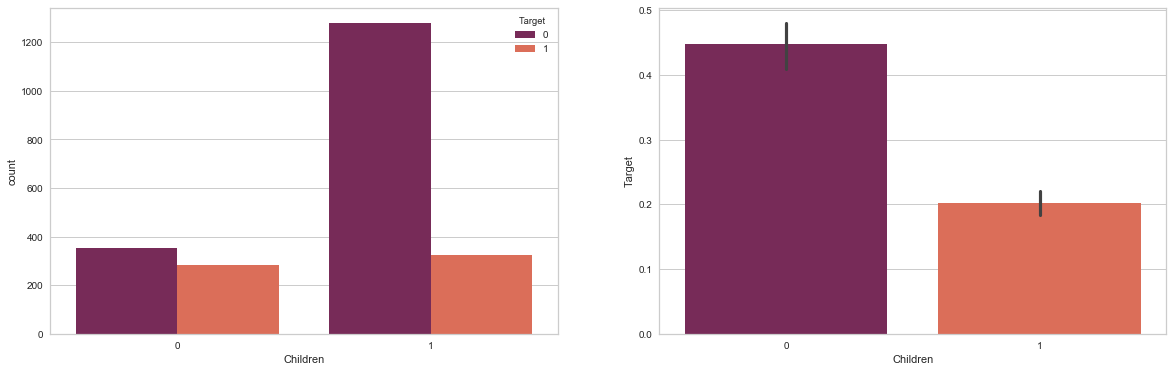

In [25]:
analise_categoricas(df,'Children')

<Figure size 1440x432 with 0 Axes>

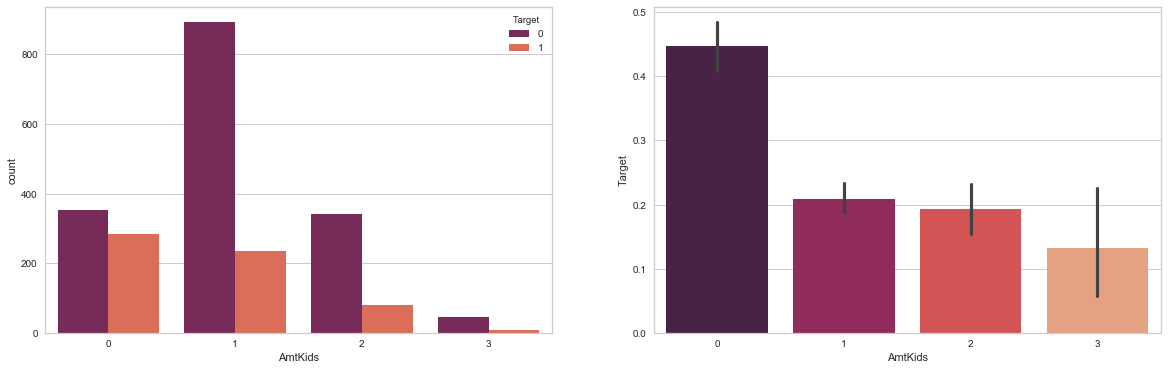

In [26]:
analise_categoricas(df,'AmtKids')

Podemos ver aqui, que pessoas com filhos tem uma maior probabilidade de aceitar o gadget, em alguma campanha. Vamos manter essa variável para modelar.

<Figure size 1440x432 with 0 Axes>

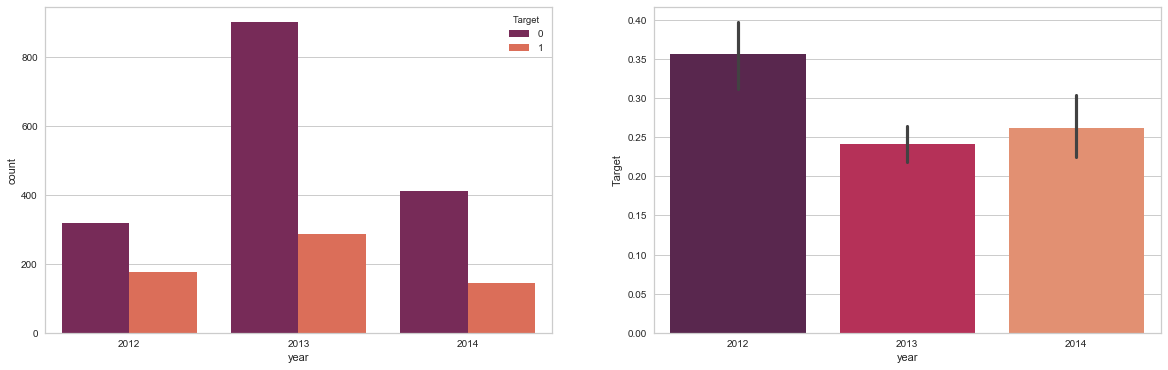

In [27]:
df['year'] = pd.to_datetime(df.Dt_Customer).dt.year
analise_categoricas(df,'year')

# Analisando as Variáveis contínuas

In [28]:
df.Income.describe()

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64

In [29]:
df['Income'] = df['Income'].fillna(df['Income'].mean())

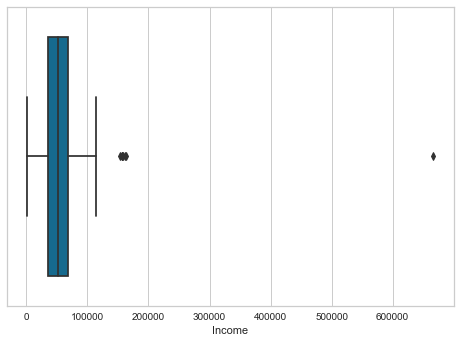

In [30]:
sns.boxplot(df['Income'])

Notamos que há 1 outlier que pode prejudicar nossa análise, vamos retirar essa observação

In [31]:
df['Income'].describe()

count      2240.000000
mean      52247.251354
std       25037.797168
min        1730.000000
25%       35538.750000
50%       51741.500000
75%       68289.750000
max      666666.000000
Name: Income, dtype: float64

In [32]:
df = df[df['Income']<666666]

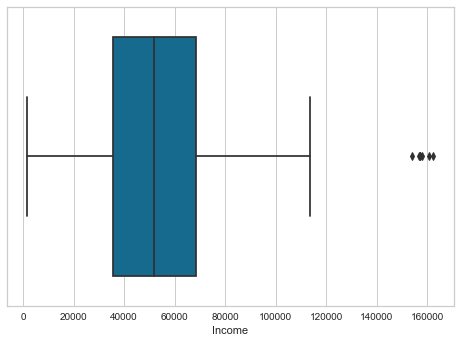

In [33]:
sns.boxplot(df['Income'])

In [34]:
df_continuo = df[["Year_Birth","Income","Recency","MntWines","MntFruits",
"MntMeatProducts","MntFishProducts","MntSweetProducts",
"MntGoldProds","NumDealsPurchases","NumWebPurchases",
"NumCatalogPurchases","NumStorePurchases","NumWebVisitsMonth","Target"]].copy()

In [35]:
df_continuo['log_income'] = np.log(df_continuo['Income'])

In [36]:
df_continuo.describe()

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Target,log_income
count,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000
mean,1968.802144,51972.834762,49.121036,304.067441,26.307727,167.016525,37.538633,27.074587,44.036177,2.324252,4.085306,2.662796,5.791425,5.316213,0.271996,10.753791
std,11.985494,21410.605416,28.963662,336.614830,39.781468,225.743829,54.637617,41.286043,52.174700,1.932345,2.779240,2.923542,3.251149,2.427144,0.445087,0.500244
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.455877
25%,1959.000000,35533.500000,24.000000,24.000000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,10.478231
50%,1970.000000,51717.000000,49.000000,174.000000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,10.853542
75%,1977.000000,68277.500000,74.000000,504.500000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,1.000000,11.131336
max,1996.000000,162397.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,11.997799


Vamos olhar as variáveis contínuas também em relação a variável resposta, vamos cortar em faixas para poder analisar melhor essas variáveis

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may

<Figure size 1440x432 with 0 Axes>

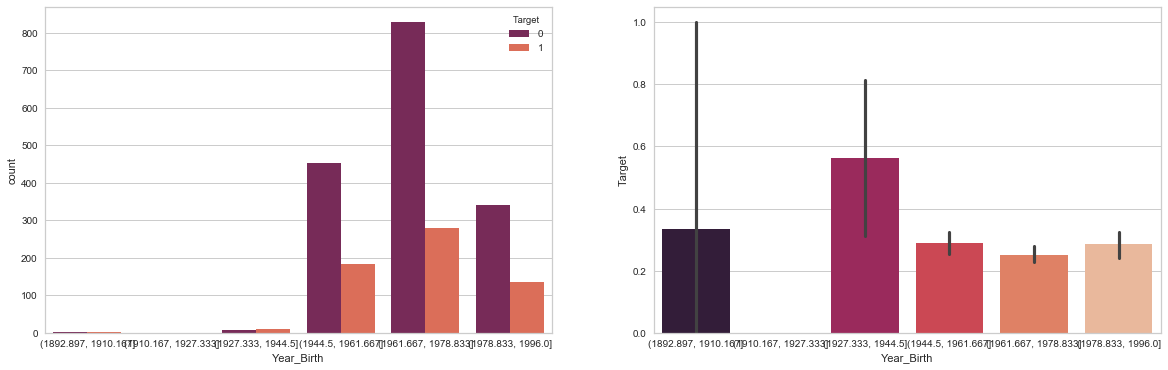

<Figure size 1440x432 with 0 Axes>

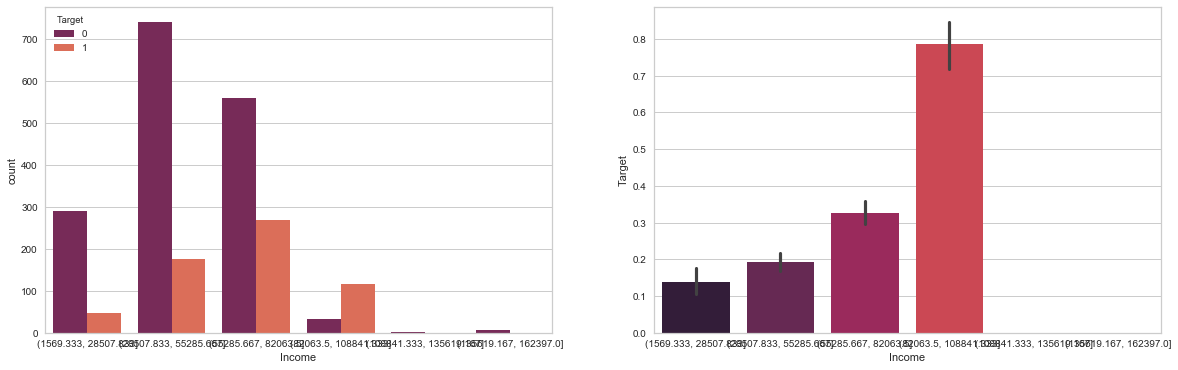

<Figure size 1440x432 with 0 Axes>

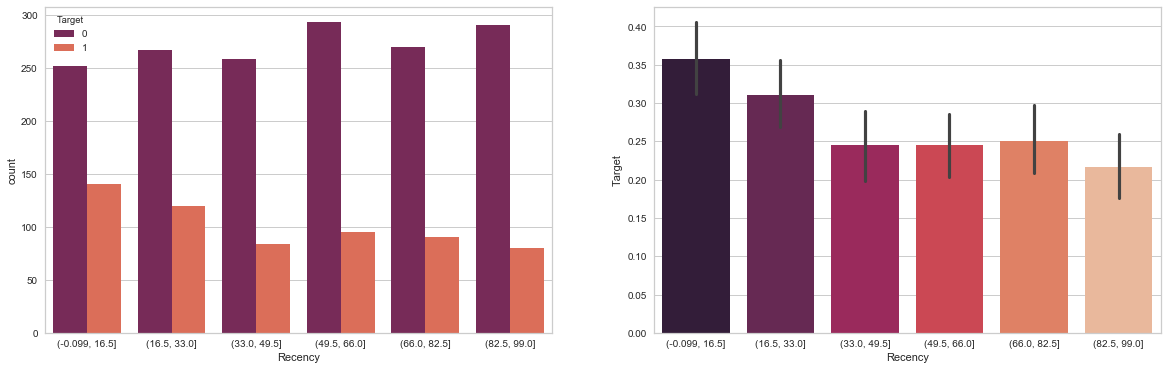

<Figure size 1440x432 with 0 Axes>

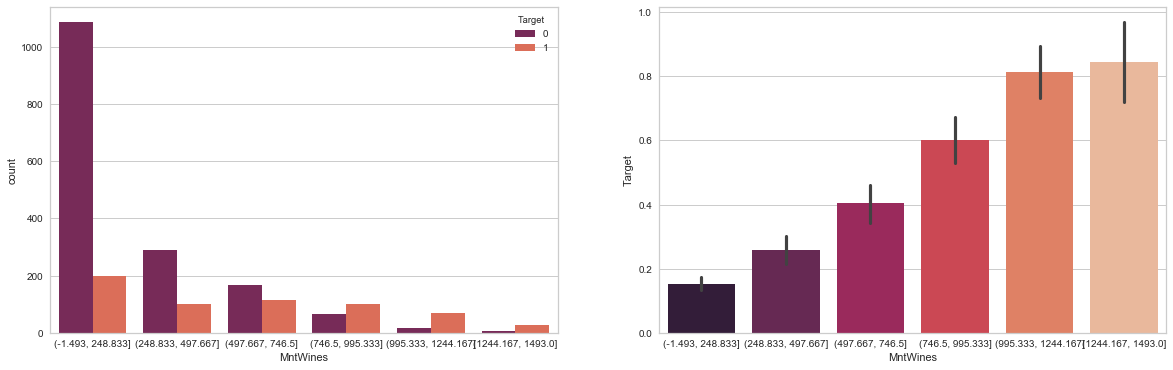

<Figure size 1440x432 with 0 Axes>

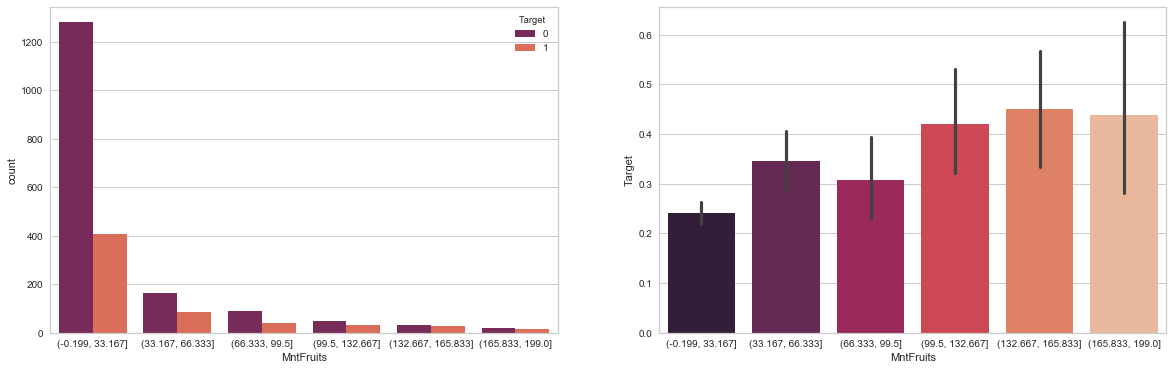

<Figure size 1440x432 with 0 Axes>

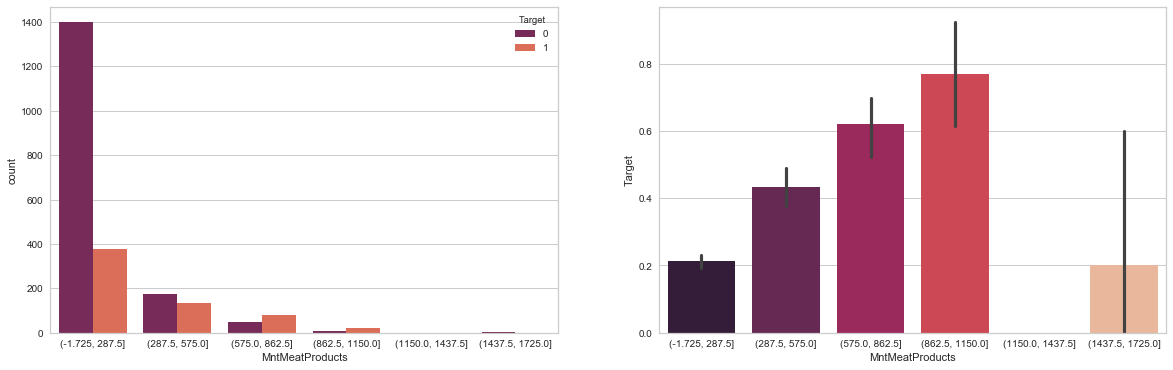

<Figure size 1440x432 with 0 Axes>

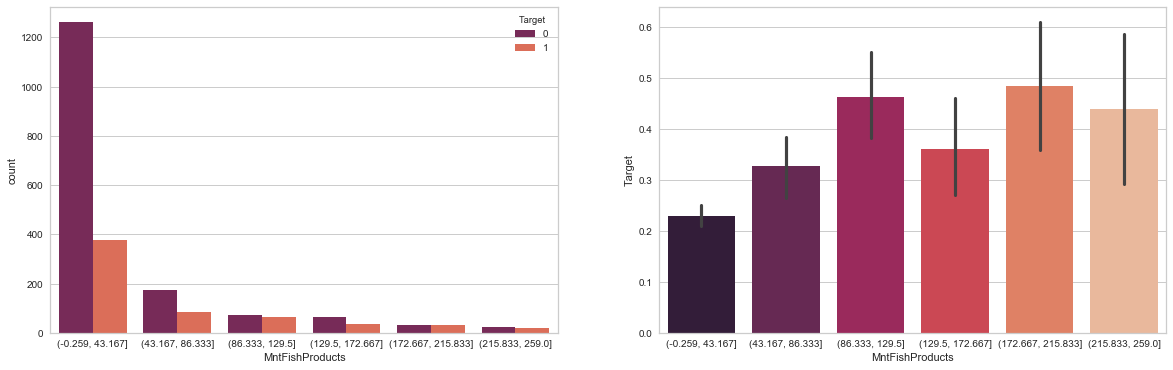

<Figure size 1440x432 with 0 Axes>

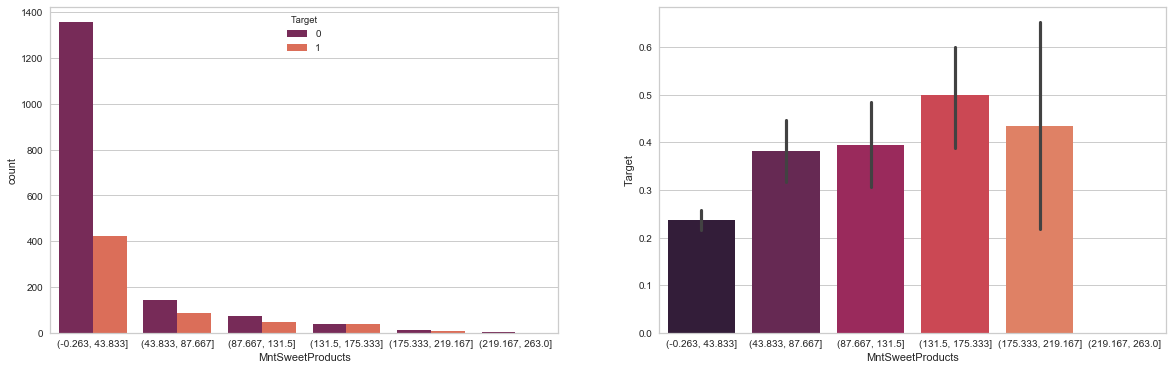

<Figure size 1440x432 with 0 Axes>

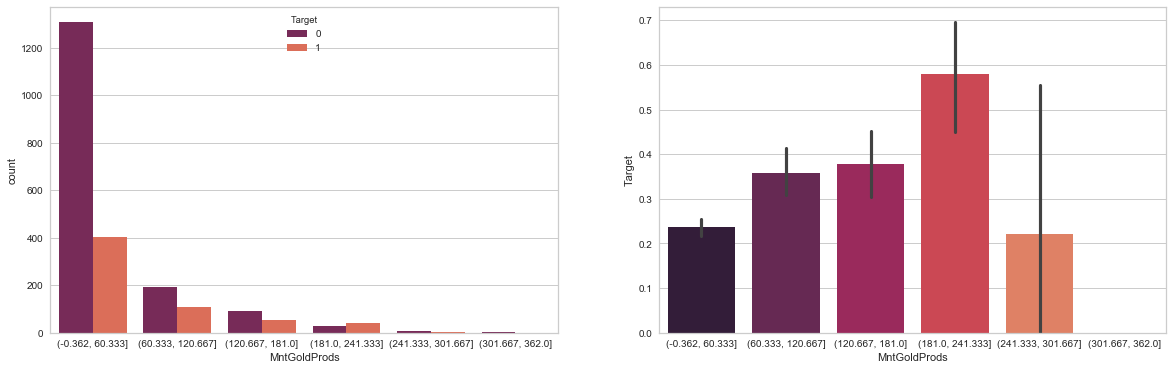

<Figure size 1440x432 with 0 Axes>

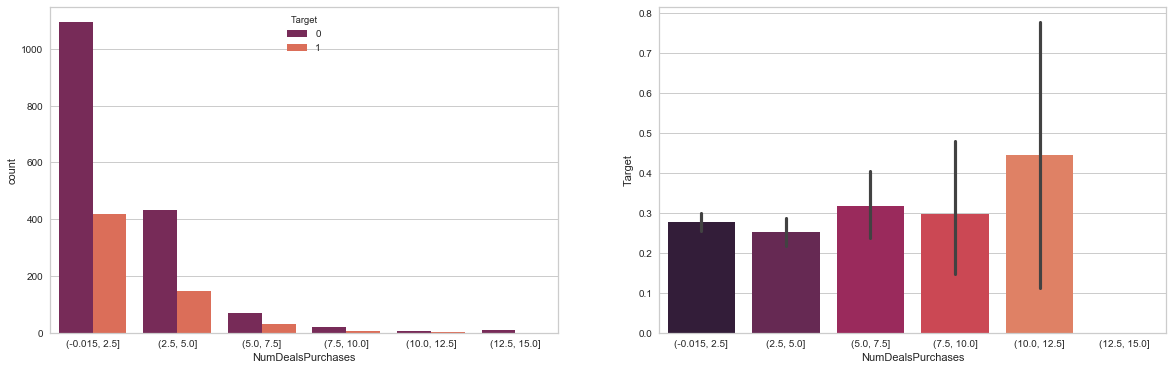

<Figure size 1440x432 with 0 Axes>

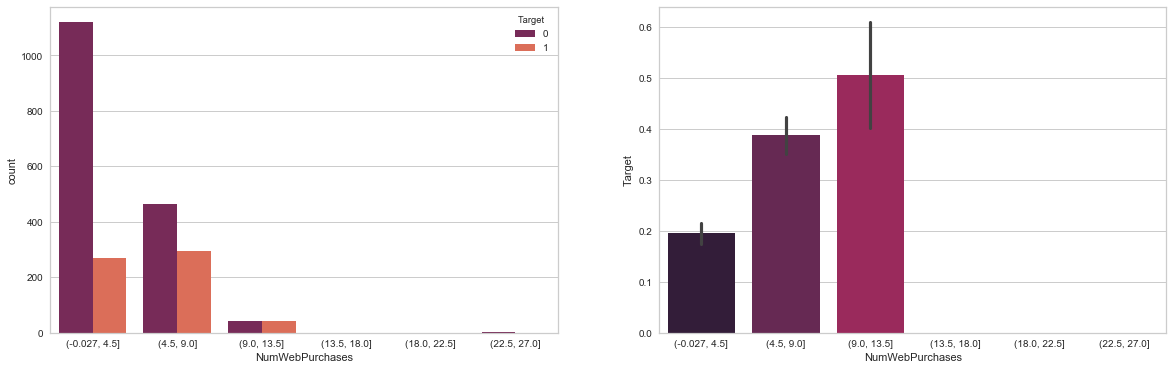

<Figure size 1440x432 with 0 Axes>

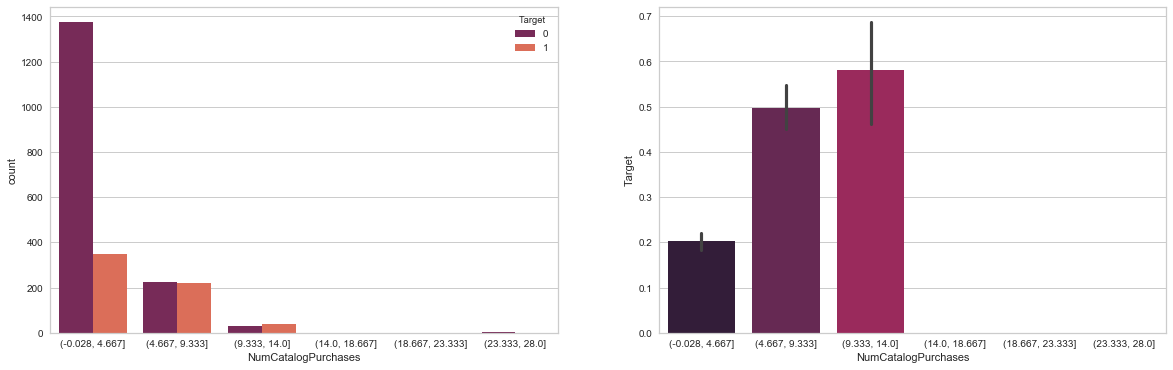

<Figure size 1440x432 with 0 Axes>

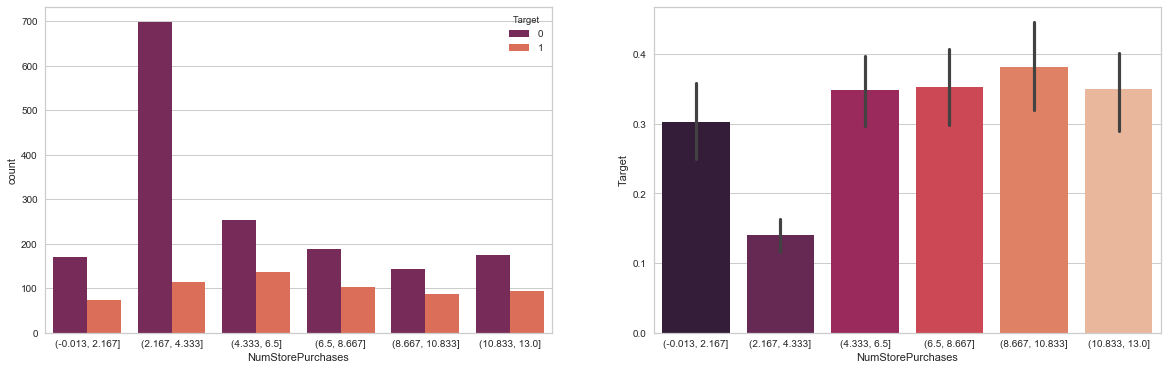

<Figure size 1440x432 with 0 Axes>

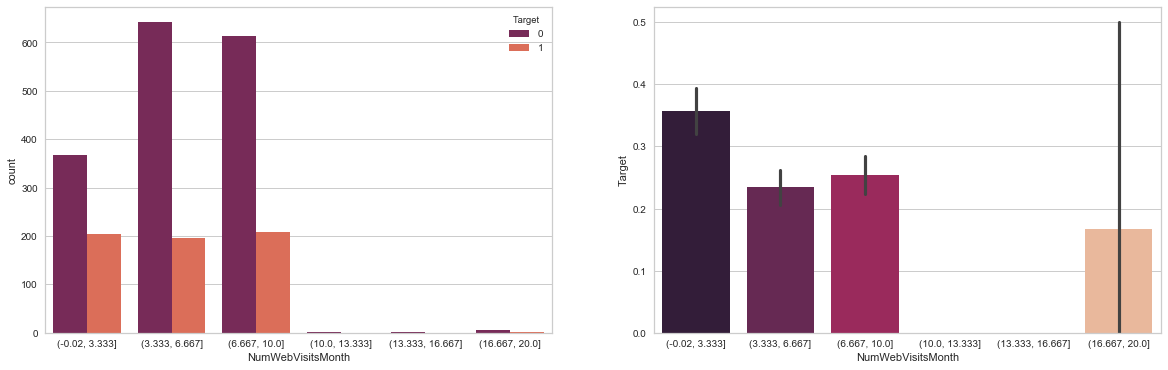

<Figure size 1440x432 with 0 Axes>

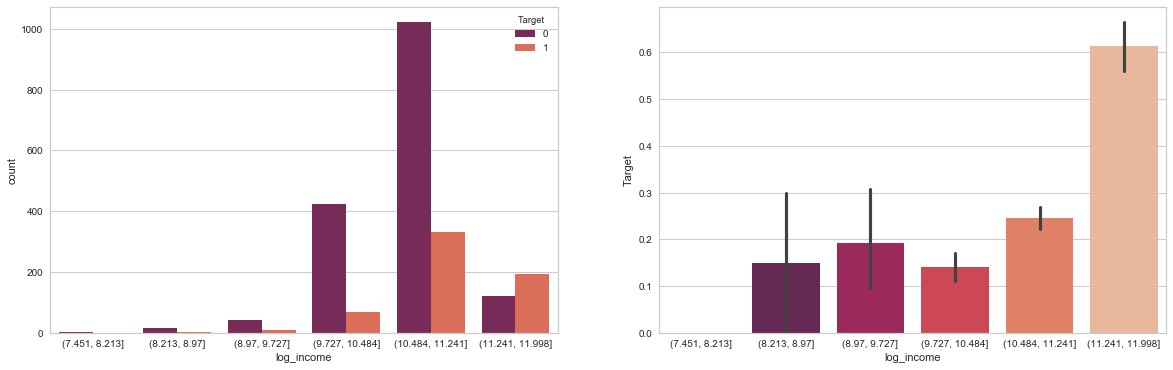

In [37]:
for colum in df_continuo.drop(columns=['Target']).columns:
    aux = pd.concat([pd.cut(df_continuo[colum], bins=6),df_continuo.Target],axis=1)
    analise_categoricas(aux,colum)

Verificamos que algumas variáveis tem mais correlação com a variável resposta do que outras, vamos manter essas informações para modelar a variável resposta em um segundo momento.

# Olhando para Clusterização

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2239 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2239 non-null   int64  
 1   Year_Birth           2239 non-null   int64  
 2   Education            2239 non-null   object 
 3   Marital_Status       2239 non-null   object 
 4   Income               2239 non-null   float64
 5   Kidhome              2239 non-null   int64  
 6   Teenhome             2239 non-null   int64  
 7   Dt_Customer          2239 non-null   object 
 8   Recency              2239 non-null   int64  
 9   MntWines             2239 non-null   int64  
 10  MntFruits            2239 non-null   int64  
 11  MntMeatProducts      2239 non-null   int64  
 12  MntFishProducts      2239 non-null   int64  
 13  MntSweetProducts     2239 non-null   int64  
 14  MntGoldProds         2239 non-null   int64  
 15  NumDealsPurchases    2239 non-null   i

Para fazer a clusterização vamos transformar as variáveis categóricas em numéricas com a a ujuda da função label_encoder

In [39]:
label_encoder = LabelEncoder()
df['Ed_Encoded'] = label_encoder.fit_transform(df.Education)

Selecionar as variáveis para olhar os clusters

In [40]:
df_cluster = df.drop(columns=(["ID","Education","Marital_Status","Kidhome",
                          "Teenhome","Dt_Customer","Z_CostContact",
                          "Z_Revenue","Target","Children","NumStorePurchases",
                          "year","Attempts",'Year_Birth',"NumWebVisitsMonth",
                              "NumDealsPurchases",'Complain'])).copy()

<Figure size 1440x432 with 0 Axes>

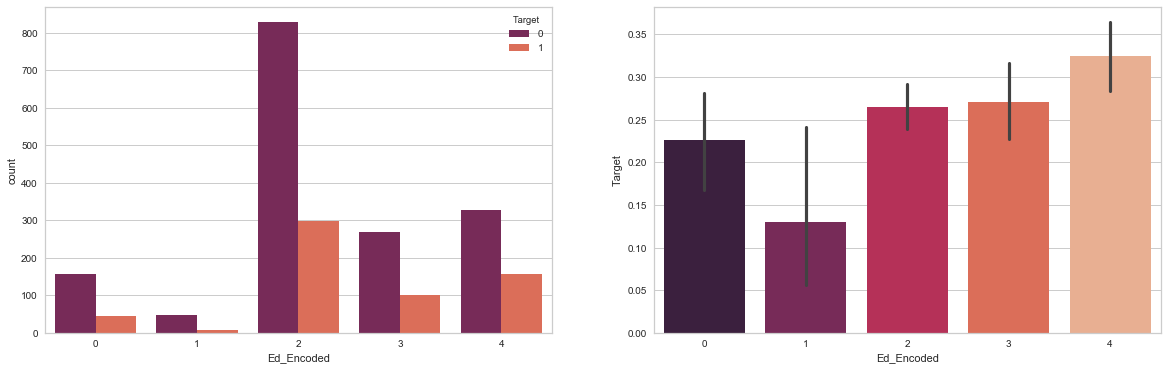

In [41]:
analise_categoricas(df,'Ed_Encoded')

In [42]:
df_cluster.describe()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,Married,AmtKids,Ed_Encoded
count,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000
mean,51972.834762,49.121036,304.067441,26.307727,167.016525,37.538633,27.074587,44.036177,4.085306,2.662796,1.608307,0.950424,2.393926
std,21410.605416,28.963662,336.614830,39.781468,225.743829,54.637617,41.286043,52.174700,2.779240,2.923542,0.557460,0.751970,1.125018
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35533.500000,24.000000,24.000000,1.000000,16.000000,3.000000,1.000000,9.000000,2.000000,0.000000,1.000000,0.000000,2.000000
50%,51717.000000,49.000000,174.000000,8.000000,67.000000,12.000000,8.000000,24.000000,4.000000,2.000000,2.000000,1.000000,2.000000
75%,68277.500000,74.000000,504.500000,33.000000,232.000000,50.000000,33.000000,56.000000,6.000000,4.000000,2.000000,1.000000,3.000000
max,162397.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,27.000000,28.000000,2.000000,3.000000,4.000000


In [43]:
#df.drop(columns=(['Ed_Encoded','Mt_Encoded']),inplace=True)

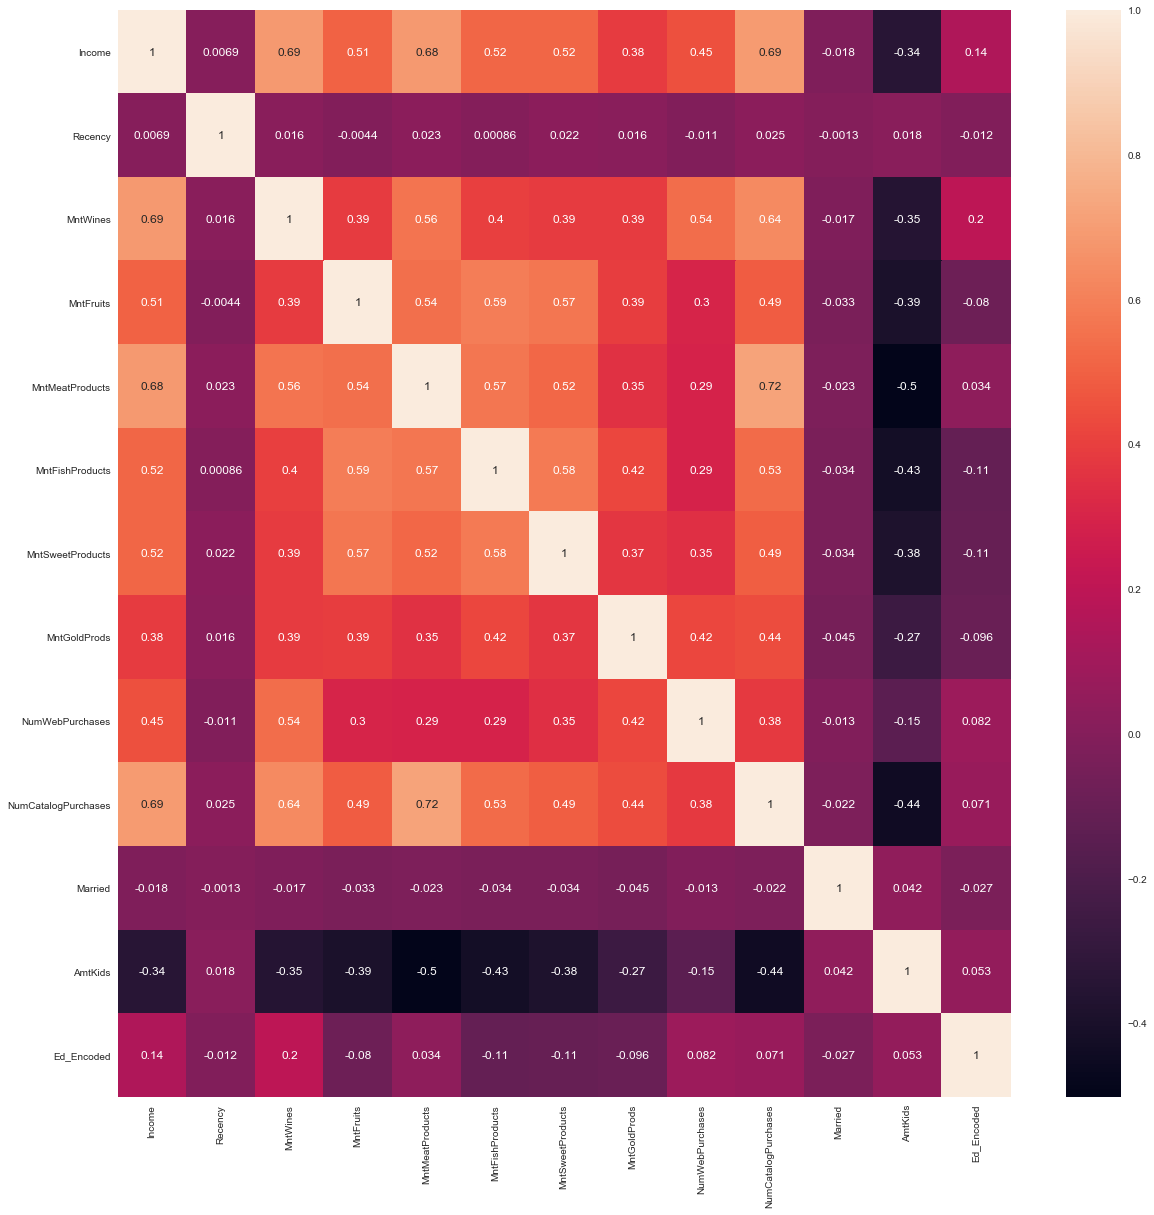

In [44]:

plt.figure(figsize=(20,20))
sns.heatmap(df_cluster.corr(), annot=True)

Com muitas variáveis de compras, correlacionadas com o income, vamos reduzir a complexidade da nossa clusterização

In [45]:
df_cluster.drop(columns=(['MntWines','MntFruits','MntMeatProducts','MntSweetProducts','NumCatalogPurchases','MntFishProducts']),inplace=True)

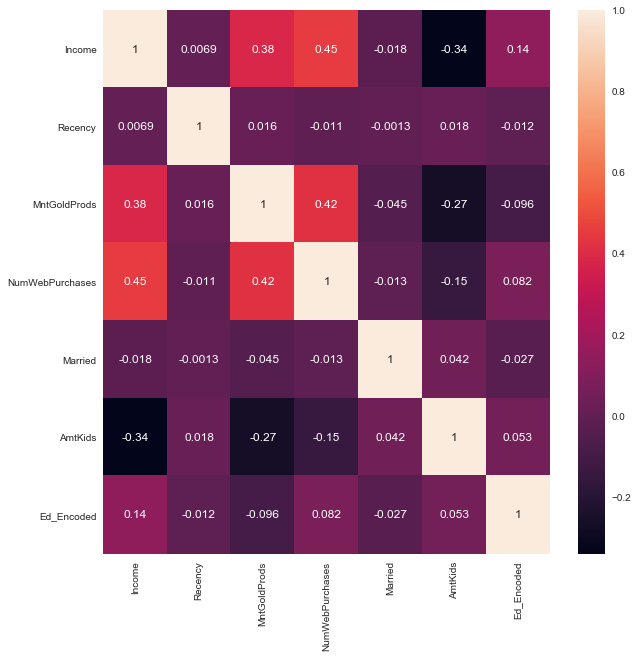

In [46]:
plt.figure(figsize=(10,10))
sns.heatmap(df_cluster.corr(), annot=True)

# K-Means

Utilizando agora as variáveis selecionadas vamos iniciar a clusterização utilizando o KMeans. 

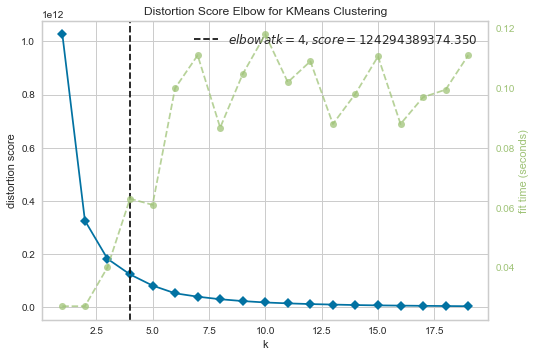

In [47]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
visualizer.fit(df_cluster)
visualizer.show()

Vamos quebrar nossos clientes em 4 segmentos.

In [48]:
scaler = StandardScaler()
scaler.fit(df_cluster)
df_cluster_scaled = scaler.transform(df_cluster)

In [49]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(df_cluster_scaled)
df['cluster'] = kmeans.labels_
df_cluster['cluster'] = kmeans.labels_


<Figure size 1440x432 with 0 Axes>

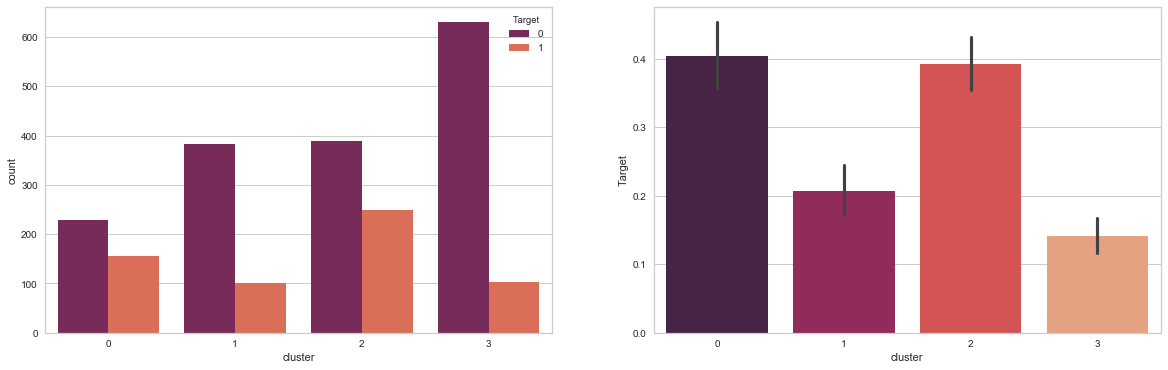

In [50]:
analise_categoricas(df,'cluster')

##### Primeiro Insight

Inicialmente, apenas com a utilização dessa nova segmentação, desenvolveria uma estratégia para oferecer o novo gadget para os clientes do cluster 0 e 2, que possuem % de aceite acima dos 35%, com isso já teriamos um ganho em relação a primeira estratégia. Vamos ver quem são esses clientes e posteriormente fazer um modelo para tentar otimizar ainda mais a abordagem de vendas.

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2239 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2239 non-null   int64  
 1   Year_Birth           2239 non-null   int64  
 2   Education            2239 non-null   object 
 3   Marital_Status       2239 non-null   object 
 4   Income               2239 non-null   float64
 5   Kidhome              2239 non-null   int64  
 6   Teenhome             2239 non-null   int64  
 7   Dt_Customer          2239 non-null   object 
 8   Recency              2239 non-null   int64  
 9   MntWines             2239 non-null   int64  
 10  MntFruits            2239 non-null   int64  
 11  MntMeatProducts      2239 non-null   int64  
 12  MntFishProducts      2239 non-null   int64  
 13  MntSweetProducts     2239 non-null   int64  
 14  MntGoldProds         2239 non-null   int64  
 15  NumDealsPurchases    2239 non-null   i

In [55]:
df.groupby(['cluster']).agg({"Attempts":['mean']})

,Attempts
,mean
cluster,
0,1.309896
1,0.904762
2,1.282132
3,0.583106


In [56]:
pd.pivot_table(df, index=['cluster'],values=['ID'],columns=['Marital_Status'], aggfunc=len,fill_value=0)

ID                                                  
Marital_Status Absurd Alone Divorced Married Single Together Widow YOLO
cluster                                                                
0                   2     0       45     139     92       90    16    0
1                   0     2      137       0    284        0    58    2
2                   0     1       50     281    104      199     3    0
3                   0     0        0     444      0      290     0    0

In [57]:
df.cluster.value_counts()

3    734
2    638
1    483
0    384
Name: cluster, dtype: int64

In [58]:
pd.pivot_table(df, index=['cluster'],values=['ID'],columns=['Education'], aggfunc=len,fill_value=0)

ID                             
Education 2n Cycle Basic Graduation Master  PhD
cluster                                        
0               60     2        248     43   31
1               40    20        248     74  101
2               15     1        255    133  234
3               88    31        375    120  120

In [59]:
df_cluster.groupby(['cluster']).agg(['mean'])

,Income,Recency,MntGoldProds,NumWebPurchases,Married,AmtKids,Ed_Encoded
,mean,mean,mean,mean,mean,mean,mean
cluster,,,,,,,
0,67006.846368,48.361979,138.994792,5.966146,1.549479,0.554688,1.955729
1,40389.163063,49.086957,20.944099,2.782609,0.875776,1.213251,2.364389
2,69719.526260,49.123824,36.703762,6.020376,1.747649,0.592476,2.893417
3,36304.529310,49.538147,15.926431,2.276567,2.000000,1.295640,2.208447


Podemos diferenciar os clusters:

* Cluster 0:
-- Alto Income compram muitos produtos classificados como Gold (clientes que mais compram essa categoria), tem uma média de menos de 1 filho e a maior quantidade de pessoas tem até Graduation : **Bastante propensos a aceitar a oferta**
* Cluster 1:
-- Baixo Income, clientes consomem poucos produtos Gold e poucas compras na web, mais de 1 filho por familia, maior quantidade de pessoas tem até o Colegial (Graduation), grande percentual de divorciados e solteiros, os clientes que aceitam, aceitam em média na primeira oferta. : **Pouco propensos a aceitar a oferta**
* Cluster 2:
-- Clientes com o maior Income, clientes que mais compram on line na média, tem menos de 1 filho por família e a maior quantidade de pessoas com Master ou PhD quanto a perfil de educação. : **Propensos a aceitar a oferta**
* Cluster 4:
-- Clientes com o menor Income, compram menos produtos Gold, menor média de compras on line. Tem a maior quantidade de filhos por família na média. Apenas clientes Casados ou Juntos, e uma alta concentração de clientes com menos graus de educação (2nd e Basic), os clientes que aceitam, aceitam em média na primeira oferta. São os clientes que mais aceitam mais rápido : **Menos propensos a aceitar a oferta**


# Modelo Preditivo

Agora com os clusters bem definidos, vamos tentar encontrar um modelo que possa predizer nossa resposta "Target", para isso vamos analisar como ficou nosso DF após todas as mudanças

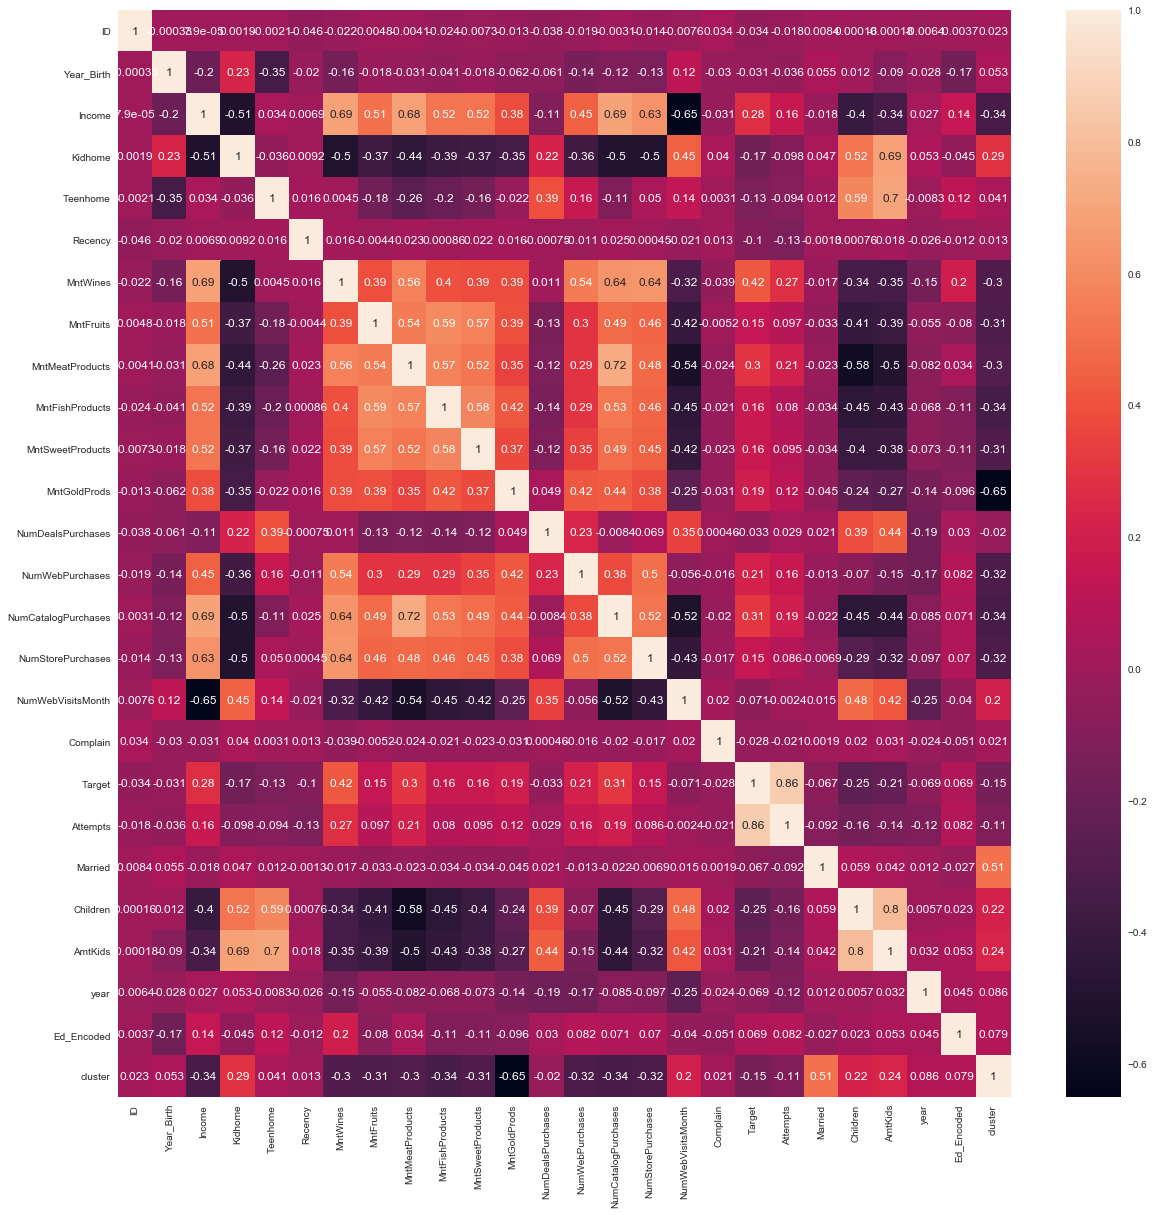

In [60]:
plt.figure(figsize=(20,20))
sns.heatmap(df.drop(columns=(['Z_CostContact','Z_Revenue','Dt_Customer','Marital_Status','Education'])).corr(), annot=True)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2239 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2239 non-null   int64  
 1   Year_Birth           2239 non-null   int64  
 2   Education            2239 non-null   object 
 3   Marital_Status       2239 non-null   object 
 4   Income               2239 non-null   float64
 5   Kidhome              2239 non-null   int64  
 6   Teenhome             2239 non-null   int64  
 7   Dt_Customer          2239 non-null   object 
 8   Recency              2239 non-null   int64  
 9   MntWines             2239 non-null   int64  
 10  MntFruits            2239 non-null   int64  
 11  MntMeatProducts      2239 non-null   int64  
 12  MntFishProducts      2239 non-null   int64  
 13  MntSweetProducts     2239 non-null   int64  
 14  MntGoldProds         2239 non-null   int64  
 15  NumDealsPurchases    2239 non-null   i

## Modelo com todas as variáveis

### Primeiros passos

Para modelar esse projeto de marketing, escolhi tres modelos para fazer os testes, serão eles Random Forest Classifier, Gradient Boost Classifier e Logistic Regression;

Como a variável target é binária, esssas foram as escolhas para termos um modelo de cada estrutura (Bagging, Tree e Regression)

In [62]:
df_model_pred = df.drop(columns=(['Attempts','ID','Dt_Customer','Marital_Status','Education']))

In [63]:
X = df_model_pred.drop(columns=['Target']).copy()
y = df_model_pred.Target.copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = 42)

In [64]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [65]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = 8)
best_clf_xgb = clf_xgb.fit(X_train,y_train)
clf_performance(best_clf_xgb,'XGB')

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   28.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 1215 out of 1215 | elapsed:  3.2min finished


XGB
Best Score: 0.8232433202417534
Best Parameters: {'colsample_bytree': 0.85, 'gamma': 2, 'learning_rate': 0.5, 'max_depth': None, 'min_child_weight': 0.01, 'n_estimators': 550, 'reg_alpha': 1, 'reg_lambda': 2, 'sampling_method': 'uniform', 'subsample': 0.6}


In [66]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = 8)
best_clf_rf = clf_rf.fit(X_train,y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   29.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 1440 out of 1440 | elapsed:  4.5min finished


Random Forest
Best Score: 0.8245111007102011
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 550}


In [67]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = 8)
best_clf_lr = clf_lr.fit(X_train,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.4s


Logistic Regression
Best Score: 0.8028041757391995
Best Parameters: {'C': 0.0006951927961775605, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=8)]: Done 185 out of 200 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.9s finished


In [68]:
y_pred_xgb = best_clf_xgb.predict(X_test)

accuracia_modelo_xgb = accuracy_score(y_test, y_pred_xgb)
mastriz_xgb = confusion_matrix(y_test, y_pred_xgb)

print(f'O score do modelo Gradient Boos nos dados de teste foi: {(accuracia_modelo_xgb*100):.2f}%')
print(f'A matriz de confusão:')
print(f'{mastriz_xgb}')

O score do modelo Gradient Boos nos dados de teste foi: 79.17%
A matriz de confusão:
[[427  43]
 [ 97 105]]


In [69]:
y_pred_rf = best_clf_rf.predict(X_test)

accuracia_modelo_rf = accuracy_score(y_test, y_pred_rf)
mastriz_rf = confusion_matrix(y_test, y_pred_rf)

print(f'O score do modelo Randon Forest nos dados de teste foi: {(accuracia_modelo_rf*100):.2f}%')
print(f'A matriz de confusão:')
print(f'{mastriz_rf}')

O score do modelo Randon Forest nos dados de teste foi: 77.98%
A matriz de confusão:
[[434  36]
 [112  90]]


In [70]:
y_pred_lr = best_clf_lr.predict(X_test)

accuracia_modelo_lr = accuracy_score(y_test, y_pred_lr)
mastriz_lr = confusion_matrix(y_test, y_pred_lr)

print(f'O score do modelo Logistic Regression nos dados de teste foi: {(accuracia_modelo_lr*100):.2f}%')
print(f'A matriz de confusão:')
print(f'{mastriz_lr}')

O score do modelo Logistic Regression nos dados de teste foi: 75.15%
A matriz de confusão:
[[442  28]
 [139  63]]


In [71]:
#Gradient Boost
y_proba_xgb = best_clf_xgb.predict_proba(X_test)[:, 1]
y_proba_xgb_train = best_clf_xgb.predict_proba(X_train)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
fpr_xgb_tr, tpr_xgb_tr, _ = roc_curve(y_train, y_proba_xgb_train)
#Randon Forest
y_proba_rf = best_clf_rf.predict_proba(X_test)[:, 1]
y_proba_rf_train = best_clf_rf.predict_proba(X_train)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_rf_tr, tpr_rf_tr, _ = roc_curve(y_train, y_proba_rf_train)
#Logistic Regression
y_proba_lr = best_clf_lr.predict_proba(X_test)[:, 1]
y_proba_lr_train = best_clf_lr.predict_proba(X_train)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_lr_tr, tpr_lr_tr, _ = roc_curve(y_train, y_proba_lr_train)

## Curva ROC

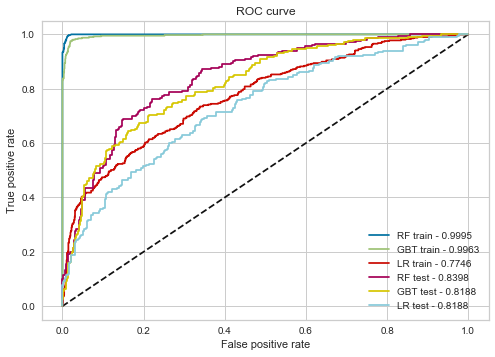

In [72]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_tr, tpr_rf_tr, label=f'RF train - {roc_auc_score(y_train, y_proba_rf_train):.4f}')
plt.plot(fpr_xgb_tr, tpr_xgb_tr, label=f'GBT train - {roc_auc_score(y_train, y_proba_xgb_train):.4f}')
plt.plot(fpr_lr_tr, tpr_lr_tr, label=f'LR train - {roc_auc_score(y_train, y_proba_lr_train):.4f}')

plt.plot(fpr_rf, tpr_rf, label=f'RF test - {roc_auc_score(y_test, y_proba_rf):.4f}')
plt.plot(fpr_xgb, tpr_xgb, label=f'GBT test - {roc_auc_score(y_test, y_proba_xgb):.4f}')
plt.plot(fpr_lr, tpr_lr, label=f'LR test - {roc_auc_score(y_test, y_proba_xgb):.4f}')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


Podemos verificar que os modelos RF e o GBX tiveram um overfit nos dados de treino, vamos reduzir o overfit, olhando para as variáveis e deixando o modelo mais simples e interpretativo

## Melhorando as variáveis

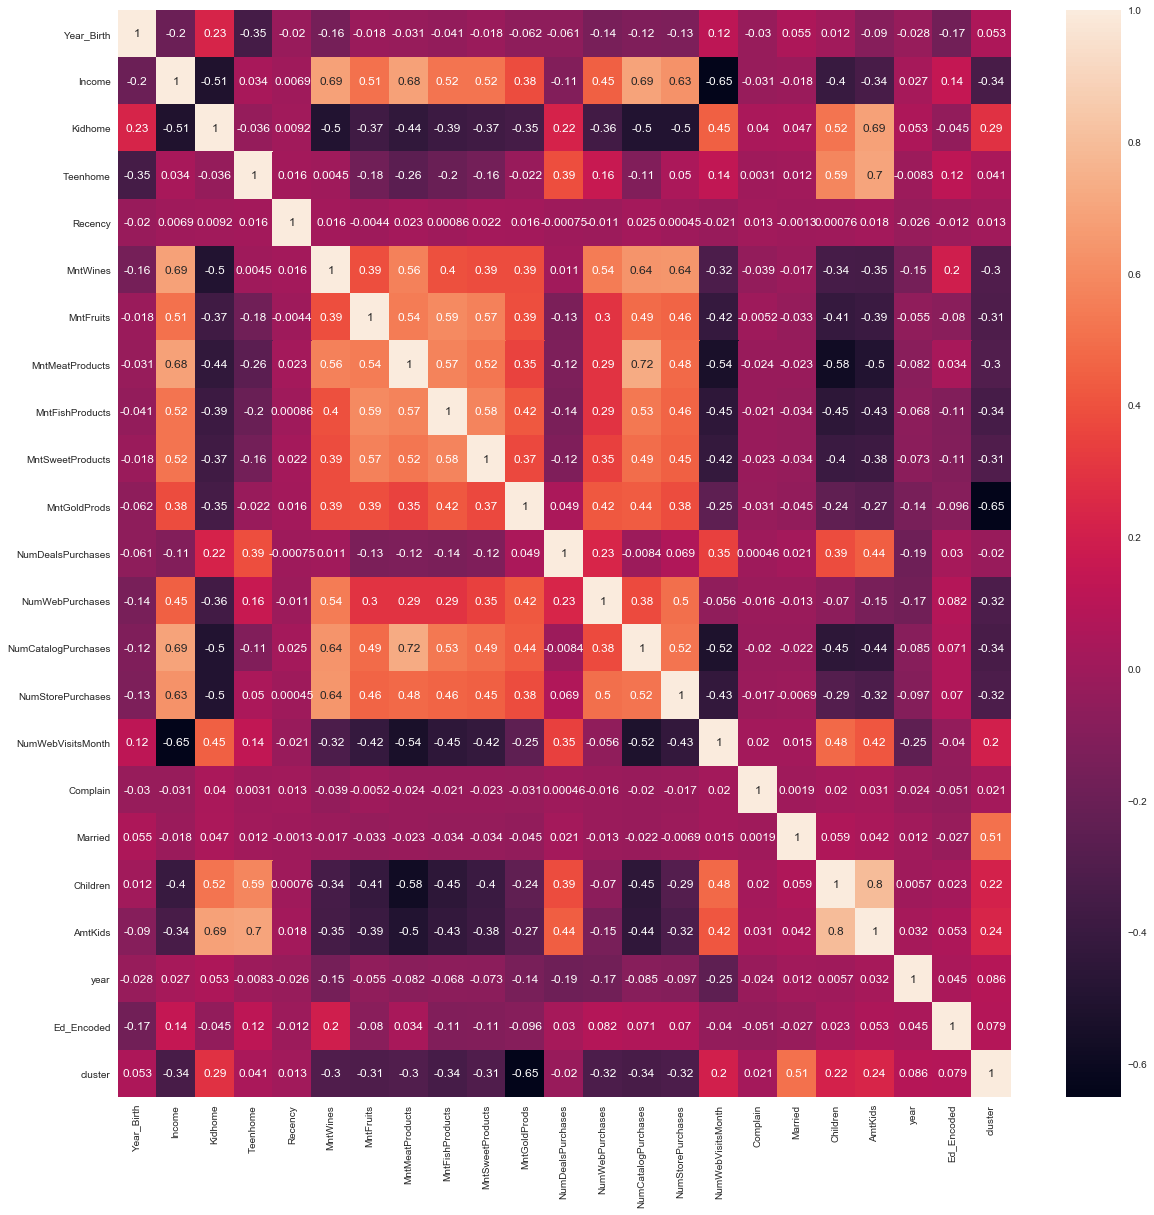

In [73]:
plt.figure(figsize=(20,20))
sns.heatmap(X.drop(columns=(['Z_CostContact','Z_Revenue'])).corr(), annot=True)

In [74]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                  Specs         Score
1                Income  1.520464e+06
5              MntWines  1.499870e+05
7       MntMeatProducts  6.089128e+04
10         MntGoldProds  5.054581e+03
8       MntFishProducts  4.745461e+03
9      MntSweetProducts  3.806504e+03
6             MntFruits  2.892731e+03
13  NumCatalogPurchases  6.745108e+02
4               Recency  3.914366e+02
12      NumWebPurchases  1.954923e+02


In [75]:
new_df_model = df[["Income","MntWines","MntMeatProducts","MntGoldProds","MntFishProducts","MntSweetProducts","MntFruits","NumCatalogPurchases","Recency","NumWebPurchases","Target"]]

In [76]:
X = new_df_model.drop(columns=['Target']).copy()
y = new_df_model.Target.copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = 42)

In [77]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [78]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = 8)
best_clf_xgb = clf_xgb.fit(X_train,y_train)
clf_performance(best_clf_xgb,'XGB')

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   16.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   41.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 1215 out of 1215 | elapsed:  2.0min finished


XGB
Best Score: 0.8136708654687531
Best Parameters: {'colsample_bytree': 0.75, 'gamma': 2, 'learning_rate': 0.5, 'max_depth': None, 'min_child_weight': 0.01, 'n_estimators': 500, 'reg_alpha': 1, 'reg_lambda': 10, 'sampling_method': 'uniform', 'subsample': 0.6}


In [79]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [10,20],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = 8)
best_clf_rf = clf_rf.fit(X_train,y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   27.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 1440 out of 1440 | elapsed:  4.4min finished


Random Forest
Best Score: 0.8174843816772146
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 400}


In [80]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = 8)
best_clf_lr = clf_lr.fit(X_train,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Logistic Regression
Best Score: 0.7951445839523006
Best Parameters: {'C': 0.0006951927961775605, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


In [81]:
y_pred_xgb = best_clf_xgb.predict(X_test)

accuracia_modelo_xgb = accuracy_score(y_test, y_pred_xgb)
mastriz_xgb = confusion_matrix(y_test, y_pred_xgb)

print(f'O score do modelo Gradient Boos nos dados de teste foi: {(accuracia_modelo_xgb*100):.2f}%')
print(f'A matriz de confusão:')
print(f'{mastriz_xgb}')

O score do modelo Gradient Boos nos dados de teste foi: 75.45%
A matriz de confusão:
[[413  57]
 [108  94]]


In [82]:
y_pred_rf = best_clf_rf.predict(X_test)

accuracia_modelo_rf = accuracy_score(y_test, y_pred_rf)
mastriz_rf = confusion_matrix(y_test, y_pred_rf)

print(f'O score do modelo Randon Forest nos dados de teste foi: {(accuracia_modelo_rf*100):.2f}%')
print(f'A matriz de confusão:')
print(f'{mastriz_rf}')

O score do modelo Randon Forest nos dados de teste foi: 75.30%
A matriz de confusão:
[[434  36]
 [130  72]]


In [83]:
y_pred_lr = best_clf_lr.predict(X_test)

accuracia_modelo_lr = accuracy_score(y_test, y_pred_lr)
mastriz_lr = confusion_matrix(y_test, y_pred_lr)

print(f'O score do modelo Logistic Regression nos dados de teste foi: {(accuracia_modelo_lr*100):.2f}%')
print(f'A matriz de confusão:')
print(f'{mastriz_lr}')

O score do modelo Logistic Regression nos dados de teste foi: 74.70%
A matriz de confusão:
[[442  28]
 [142  60]]


In [84]:
#Gradient Boost
y_proba_xgb = best_clf_xgb.predict_proba(X_test)[:, 1]
y_proba_xgb_train = best_clf_xgb.predict_proba(X_train)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
fpr_xgb_tr, tpr_xgb_tr, _ = roc_curve(y_train, y_proba_xgb_train)
#Randon Forest
y_proba_rf = best_clf_rf.predict_proba(X_test)[:, 1]
y_proba_rf_train = best_clf_rf.predict_proba(X_train)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_rf_tr, tpr_rf_tr, _ = roc_curve(y_train, y_proba_rf_train)
#Logistic Regression
y_proba_lr = best_clf_lr.predict_proba(X_test)[:, 1]
y_proba_lr_train = best_clf_lr.predict_proba(X_train)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_lr_tr, tpr_lr_tr, _ = roc_curve(y_train, y_proba_lr_train)

## Curva ROC

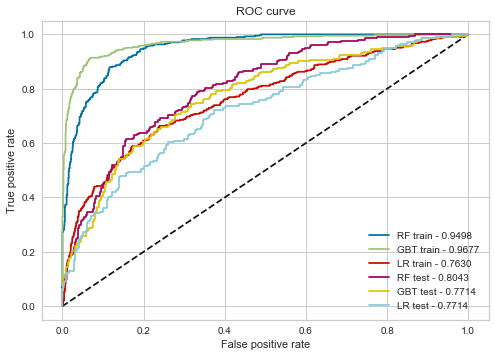

In [85]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_tr, tpr_rf_tr, label=f'RF train - {roc_auc_score(y_train, y_proba_rf_train):.4f}')
plt.plot(fpr_xgb_tr, tpr_xgb_tr, label=f'GBT train - {roc_auc_score(y_train, y_proba_xgb_train):.4f}')
plt.plot(fpr_lr_tr, tpr_lr_tr, label=f'LR train - {roc_auc_score(y_train, y_proba_lr_train):.4f}')

plt.plot(fpr_rf, tpr_rf, label=f'RF test - {roc_auc_score(y_test, y_proba_rf):.4f}')
plt.plot(fpr_xgb, tpr_xgb, label=f'GBT test - {roc_auc_score(y_test, y_proba_xgb):.4f}')
plt.plot(fpr_lr, tpr_lr, label=f'LR test - {roc_auc_score(y_test, y_proba_xgb):.4f}')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


Sem perder muito poder de predição, analisando pelos dados de teste. Podemos utilizar a versão com as 10 variáveis mais importantes para realizar a predição da nossa campanha, com uma complexidade menor, e ainda sim um bom poder de predição **80% para os dados de teste**

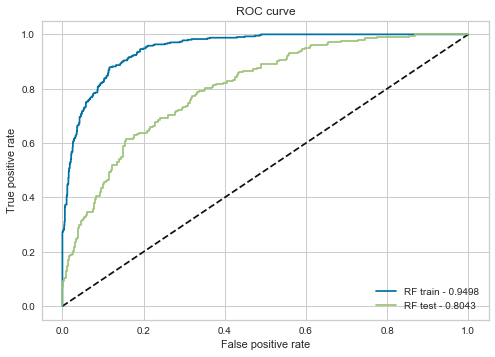

In [86]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_tr, tpr_rf_tr, label=f'RF train - {roc_auc_score(y_train, y_proba_rf_train):.4f}')


plt.plot(fpr_rf, tpr_rf, label=f'RF test - {roc_auc_score(y_test, y_proba_rf):.4f}')


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [87]:
print(f'A tabela com as importâncias de cada feature para o modelo são:')
pd.DataFrame(best_clf_rf.best_estimator_.feature_importances_,X_test.columns, columns=['Values'])

A tabela com as importâncias de cada feature para o modelo são:


,Values
Income,0.141600
MntWines,0.403198
MntMeatProducts,0.079769
MntGoldProds,0.090986
MntFishProducts,0.045946
MntSweetProducts,0.038671
MntFruits,0.038146
NumCatalogPurchases,0.040563
Recency,0.092891
NumWebPurchases,0.028229


# Conclusão

Podemos concluir que a clusterização encontrada pode dividir nossos usuários de uma maneira satisfatória, com distinção entre clusters, para uma primeira abordagem podemos utilizar essa metodologia para melhorar o sucesso na oferta dos clientes ofertando primeiro ao Cluster 3, então ao 1, e caso haja necessidade poderíamos abordar os demais clusters. 

Num segundo momento de regra de negócio, podemos aplicar o modelo de Randon Forest, com as variáveis selecionadas para inferir se o cliente iria aceitar a proposta ou não, buscando assim um melhor rendimento da campanha.

# Extras

In [88]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

In [96]:
X = new_df_model.drop(columns=['Target']).copy()
y = new_df_model.Target.copy()

scale.fit(X)

X = scale.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 456)

In [97]:
print(f' Shape de X {X.shape}')
print(f' Shape de y {y.shape}')

 Shape de X (2239, 10)
 Shape de y (2239,)


array([[ 0.28801346,  0.98333899,  1.679196  , ...,  2.51025708,
         0.30662377,  1.40886293],
       [-0.2629581 , -0.87082589, -0.71343033, ..., -0.5688877 ,
        -0.38405089, -1.11037366],
       [ 0.91751505,  0.36231261, -0.1773048 , ..., -0.2267605 ,
        -0.79845569,  1.40886293],
       ...,
       [ 0.23396274,  1.79453612,  0.22146626, ...,  0.1153667 ,
         1.44623696, -0.75048272],
       [ 0.80689095,  0.36825545,  0.20817389, ...,  0.79962109,
        -1.42006289,  0.68908105],
       [ 0.04186549, -0.65391237, -0.46973691, ..., -0.5688877 ,
        -0.31498343, -0.39059178]])

In [90]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [103]:
model = Sequential()
model.add(Dense(10, input_dim=10, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
opt = optimizers.Adam(learning_rate=0.0001)
es = EarlyStopping(monitor='val_loss', mode='min',verbose=1, patience=200)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit the keras model on the dataset
history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=2000, batch_size=32, callbacks=[es])
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/2000
56/56 [==============================] - 0s 2ms/step - loss: 0.7195 - accuracy: 0.4913 - val_loss: 0.7040 - val_accuracy: 0.5469
Epoch 2/2000
56/56 [==============================] - 0s 786us/step - loss: 0.7049 - accuracy: 0.5455 - val_loss: 0.6879 - val_accuracy: 0.6138
Epoch 3/2000
56/56 [==============================] - 0s 732us/step - loss: 0.6908 - accuracy: 0.5985 - val_loss: 0.6725 - val_accuracy: 0.6696
Epoch 4/2000
56/56 [==============================] - 0s 732us/step - loss: 0.6774 - accuracy: 0.6438 - val_loss: 0.6575 - val_accuracy: 0.7098
Epoch 5/2000
56/56 [==============================] - 0s 714us/step - loss: 0.6646 - accuracy: 0.6650 - val_loss: 0.6431 - val_accuracy: 0.7121
Epoch 6/2000
56/56 [==============================] - 0s 732us/step - loss: 0.6524 - accuracy: 0.6762 - val_loss: 0.6295 - val_accuracy: 0.7232
Epoch 7/2000
56/56 [==============================] - 0s 714us/step - loss: 0.6408 - accuracy: 0.6812 - val_loss: 0.6166 - val_accuracy: 0

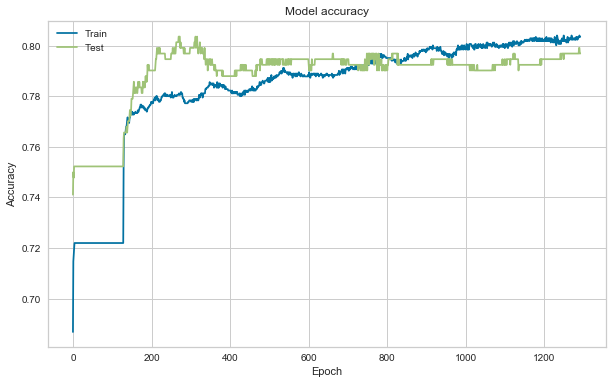

In [101]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.ylim(0.55,0.8)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

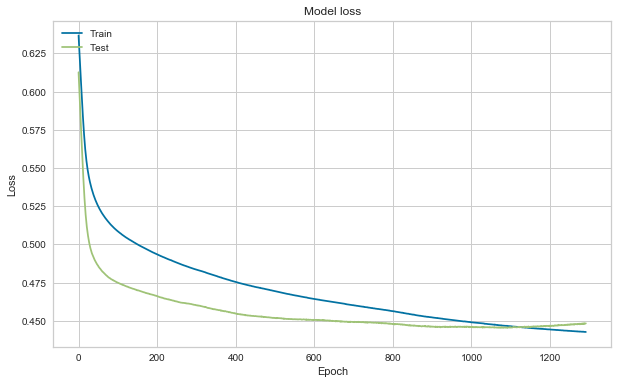

In [102]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
#plt.ylim(0.45,0.7)
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()